In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
import pandas as pd
from bs4 import BeautifulSoup
import itertools
import more_itertools
import numpy as np
import pickle


In [2]:
device

device(type='cuda')

In [3]:
df=pd.read_csv('yelp.csv')

In [4]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
col_text = 'text'
col_target = 'cool'

In [6]:
cls_arr = np.sort(df[col_target].unique()).tolist()
classes = len(cls_arr)

In [7]:
length = df.shape[0]
train_len = int(0.8*length)
val_len = int(0.1*length)

In [8]:
train = df[:train_len]
val = df[train_len:train_len+val_len]
test = df[train_len+val_len:]

In [9]:
def clean_str(string, max_seq_len):
    """
    adapted from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = BeautifulSoup(string, "lxml").text
    string = re.sub(r"[^A-Za-z0-9(),!?\"\`]", " ", string)
    string = re.sub(r"\"s", " \"s", string)
    string = re.sub(r"\"ve", " \"ve", string)
    string = re.sub(r"n\"t", " n\"t", string)
    string = re.sub(r"\"re", " \"re", string)
    string = re.sub(r"\"d", " \"d", string)
    string = re.sub(r"\"ll", " \"ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    s =string.strip().lower().split(" ")
    if len(s) > max_seq_len:
        return s[0:max_seq_len] 
    return s

In [10]:
def create3DList(df,col, max_sent_len,max_seq_len):
    x=[]
    for docs in df[col].as_matrix():
        x1=[]
        idx = 0
        for seq in "|||".join(re.split("[.?!]", docs)).split("|||"):
            x1.append(clean_str(seq,max_sent_len))
            if(idx>=max_seq_len-1):
                break
            idx= idx+1
        x.append(x1)
    return x

In [11]:
max_sent_len = 12
max_seq_len = 25

In [12]:
#divides review in sentences and sentences into word creating a 3DList

x_train = create3DList(train,col_text, max_sent_len,max_seq_len)
x_val = create3DList(val, col_text, max_sent_len,max_seq_len)
x_test = create3DList(test, col_text, max_sent_len,max_seq_len)
print("x_train: {}".format(len(x_train)))
print("x_val: {}".format(len(x_val)))
print("x_test: {}".format(len(x_test)))

/home/root1/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/root1/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://stevelerer" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


x_train: 8000
x_val: 1000
x_test: 1000


/home/root1/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [13]:
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

In [14]:
stoplist = stopwords.words('english') + list(string.punctuation)
stemmer = SnowballStemmer('english')
x_train_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_train]
x_test_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_test]
x_val_texts = [[[stemmer.stem(word.lower()) for word in sent  if word not in stoplist] for sent in para]
         for para in x_val]
# texts = [stemmer.stem(word) for word in filtered]
# remove single words
from collections import defaultdict
frequency1 = defaultdict(int)
for texts in x_train_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_test_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
for texts in x_val_texts:     
    for text in texts:
        for token in text:
            frequency1[token] += 1
x_train_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_train_texts]

x_test_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_test_texts]
x_val_texts = [[[token for token in text if frequency1[token] > 5]
         for text in texts] for texts in x_val_texts]

In [15]:
texts = list(more_itertools.collapse(x_train_texts[:] + x_test_texts[:] + x_val_texts[:],levels=1))

In [16]:
word2vec = Word2Vec(texts,size=200, min_count=5)

In [17]:
word2vec.save("dictonary_yelp")

In [18]:
x_train_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_train_texts]

In [19]:
x_test_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_test_texts]

In [20]:
x_val_vec = [[[word2vec.wv.vocab[token].index for token in text]
         for text in texts] for texts in x_val_texts]

In [21]:
weights = torch.FloatTensor(word2vec.wv.syn0).cuda()

/home/root1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [22]:
vocab_size = len(word2vec.wv.vocab)

In [23]:
y_train = train[col_target].tolist()
y_test = test[col_target].tolist()
y_val = val[col_target].tolist()

In [24]:
def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i]
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0).unsqueeze(0)

In [25]:
class WordRNN(nn.Module):
    def __init__(self, vocab_size,embedsize, batch_size, hid_size):
        super(WordRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        ## Word Encoder
        self.embed = nn.Embedding(vocab_size, embedsize)
        self.wordRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Word Attention
        self.wordattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
    def forward(self,inp, hid_state):
        emb_out  = self.embed(inp)

        out_state, hid_state = self.wordRNN(emb_out, hid_state)

        word_annotation = self.wordattn(out_state)
        attn = F.softmax(self.attn_combine(word_annotation),dim=1)

        sent = attention_mul(out_state,attn)
        return sent, hid_state


In [26]:
class SentenceRNN(nn.Module):
    def __init__(self,vocab_size,embedsize, batch_size, hid_size,c):
        super(SentenceRNN, self).__init__()
        self.batch_size = batch_size
        self.embedsize = embedsize
        self.hid_size = hid_size
        self.cls = c
        self.wordRNN = WordRNN(vocab_size,embedsize, batch_size, hid_size)
        ## Sentence Encoder
        self.sentRNN = nn.GRU(embedsize, hid_size, bidirectional=True)
        ## Sentence Attention
        self.sentattn = nn.Linear(2*hid_size, 2*hid_size)
        self.attn_combine = nn.Linear(2*hid_size, 2*hid_size,bias=False)
        self.doc_linear = nn.Linear(2*hid_size, c)
    
    def forward(self,inp, hid_state_sent, hid_state_word):
        s = None
        for i in range(len(inp[0])):
            r = None
            for j in range(len(inp)):
                if(r is None):
                    r = [inp[j][i]]
                else:
                    r.append(inp[j][i])
            r1 = np.asarray([sub_list + [0] * (max_seq_len - len(sub_list)) for sub_list in r])
            _s, state_word = self.wordRNN(torch.cuda.LongTensor(r1).view(-1,batch_size), hid_state_word)
            if(s is None):
                s = _s
            else:
                s = torch.cat((s,_s),0)

                out_state, hid_state = self.sentRNN(s, hid_state_sent)
        sent_annotation = self.sentattn(out_state)
        attn = F.softmax(self.attn_combine(sent_annotation),dim=1)

        doc = attention_mul(out_state,attn)
        d = self.doc_linear(doc)
        cls = F.log_softmax(d.view(-1,self.cls),dim=1)
        return cls, hid_state
    
    def init_hidden_sent(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)).cuda()
    
    def init_hidden_word(self):
            return Variable(torch.zeros(2, self.batch_size, self.hid_size)).cuda()


In [27]:
y_train_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_train]
y_val_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_val]
y_test_tensor =  [torch.cuda.FloatTensor([cls_arr.index(label)]) for label in y_test]

In [28]:
max_seq_len = max([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)])
max_sent_len = max([len(sent) for sent in (x_train_vec + x_val_vec + x_test_vec)])

In [29]:
max_seq_len

12

In [30]:
max_sent_len

25

In [31]:
np.percentile(np.array([len(seq) for seq in itertools.chain.from_iterable(x_train_vec +x_val_vec + x_test_vec)]),90)

6.0

In [32]:
np.percentile(np.array([len(sent) for sent in (x_train_vec +x_val_vec + x_test_vec)]),90)

25.0

In [33]:
X_train_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_train_vec]
X_val_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_val_vec]
X_test_pad = [sub_list + [[0]] * (max_sent_len - len(sub_list)) for sub_list in x_test_vec]

In [34]:
batch_size = 64

In [35]:
def train_data(batch_size, review, targets, sent_attn_model, sent_optimizer, criterion):

    state_word = sent_attn_model.init_hidden_word()
    state_sent = sent_attn_model.init_hidden_sent()
    sent_optimizer.zero_grad()
            
    y_pred, state_sent = sent_attn_model(review, state_sent, state_word)

    loss = criterion(y_pred.cuda(), torch.cuda.LongTensor(targets)) 

    max_index = y_pred.max(dim = 1)[1]
    correct = (max_index == torch.cuda.LongTensor(targets)).sum()
    acc = float(correct)/batch_size

    loss.backward()
    
    sent_optimizer.step()
    
    return loss.data[0],acc

In [36]:
hid_size = 100
embedsize = 200 

In [37]:
sent_attn = SentenceRNN(vocab_size,embedsize,batch_size,hid_size,classes)
sent_attn.cuda()
sent_attn.wordRNN.embed.from_pretrained(weights)
torch.backends.cudnn.benchmark=True

In [38]:
learning_rate = 1e-3
momentum = 0.9

sent_optimizer = torch.optim.SGD(sent_attn.parameters(), lr=learning_rate, momentum= momentum)

criterion = nn.NLLLoss()

In [39]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [40]:
def gen_batch(x,y,batch_size):
    k = random.sample(range(len(x)-1),batch_size)
    x_batch=[]
    y_batch=[]

    for t in k:
        x_batch.append(x[t])
        y_batch.append(y[t])

    return [x_batch,y_batch]

In [41]:
def validation_accuracy(batch_size, x_val,y_val,sent_attn_model):
    acc = []
    val_length = len(x_val)
    for j in range(int(val_length/batch_size)):
        x,y = gen_batch(x_val,y_val,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.cuda.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [42]:
def train_early_stopping(batch_size, x_train, y_train, x_val, y_val, sent_attn_model, 
                         sent_attn_optimiser, loss_criterion, num_epoch,
                         print_loss_every = 50, code_test=True):
    start = time.time()
    loss_full = []
    loss_epoch = []
    acc_epoch = []
    acc_full = []
    val_acc = []
    epoch_counter = 0
    train_length = len(x_train)
    for i in range(1, num_epoch + 1):
        loss_epoch = []
        acc_epoch = []
        for j in range(int(train_length/batch_size)):
            x,y = gen_batch(x_train,y_train,batch_size)
            loss,acc = train_data(batch_size, x, y, sent_attn_model, sent_attn_optimiser, loss_criterion)
            loss_epoch.append(loss)
            acc_epoch.append(acc)
            if (code_test and j % int(print_loss_every/batch_size) == 0) :
                print ('Loss at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(loss_epoch)))
                print ('Accuracy at %d paragraphs, %d epoch,(%s) is %f' %(j*batch_size, i, timeSince(start), np.mean(acc_epoch)))
        
        loss_full.append(np.mean(loss_epoch))
        acc_full.append(np.mean(acc_epoch))
        torch.save(sent_attn_model.state_dict(), 'sent_attn_model_yelp.pth')
        print ('Loss after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(loss_epoch)))
        print ('Train Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), np.mean(acc_epoch)))

        val_acc.append(validation_accuracy(batch_size, x_val, y_val, sent_attn_model)) 
        print ('Validation Accuracy after %d epoch,(%s) is %f' %(i, timeSince(start), val_acc[-1]))
    return loss_full,acc_full,val_acc


In [43]:
epoch = 200

In [44]:
loss_full, acc_full, val_acc = train_early_stopping(batch_size, X_train_pad, y_train_tensor, X_val_pad,
                                y_val_tensor, sent_attn, sent_optimizer, criterion, epoch, 10000, False)



/home/root1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss after 1 epoch,(0m 29s) is 3.108306
Train Accuracy after 1 epoch,(0m 29s) is 0.486375
Validation Accuracy after 1 epoch,(0m 30s) is 0.628125
Loss after 2 epoch,(1m 0s) is 2.364582
Train Accuracy after 2 epoch,(1m 0s) is 0.625000
Validation Accuracy after 2 epoch,(1m 1s) is 0.636458
Loss after 3 epoch,(1m 31s) is 1.757459
Train Accuracy after 3 epoch,(1m 31s) is 0.624125
Validation Accuracy after 3 epoch,(1m 32s) is 0.641667
Loss after 4 epoch,(2m 2s) is 1.536340
Train Accuracy after 4 epoch,(2m 2s) is 0.626625
Validation Accuracy after 4 epoch,(2m 3s) is 0.653125
Loss after 5 epoch,(2m 32s) is 1.433756
Train Accuracy after 5 epoch,(2m 32s) is 0.627750
Validation Accuracy after 5 epoch,(2m 33s) is 0.648958
Loss after 6 epoch,(3m 3s) is 1.392134
Train Accuracy after 6 epoch,(3m 3s) is 0.623125
Validation Accuracy after 6 epoch,(3m 4s) is 0.644792
Loss after 7 epoch,(3m 35s) is 1.346634
Train Accuracy after 7 epoch,(3m 35s) is 0.628250
Validation Accuracy after 7 epoch,(3m 36s) is 0.6

Validation Accuracy after 56 epoch,(28m 37s) is 0.618750
Loss after 57 epoch,(29m 6s) is 1.246333
Train Accuracy after 57 epoch,(29m 6s) is 0.626875
Validation Accuracy after 57 epoch,(29m 7s) is 0.647917
Loss after 58 epoch,(29m 37s) is 1.245983
Train Accuracy after 58 epoch,(29m 37s) is 0.621875
Validation Accuracy after 58 epoch,(29m 38s) is 0.679167
Loss after 59 epoch,(30m 7s) is 1.250815
Train Accuracy after 59 epoch,(30m 7s) is 0.627875
Validation Accuracy after 59 epoch,(30m 8s) is 0.638542
Loss after 60 epoch,(30m 38s) is 1.265061
Train Accuracy after 60 epoch,(30m 38s) is 0.616875
Validation Accuracy after 60 epoch,(30m 39s) is 0.633333
Loss after 61 epoch,(31m 8s) is 1.204380
Train Accuracy after 61 epoch,(31m 8s) is 0.639125
Validation Accuracy after 61 epoch,(31m 9s) is 0.653125
Loss after 62 epoch,(31m 39s) is 1.261976
Train Accuracy after 62 epoch,(31m 39s) is 0.615875
Validation Accuracy after 62 epoch,(31m 40s) is 0.607292
Loss after 63 epoch,(32m 9s) is 1.231365
Train

Loss after 111 epoch,(56m 40s) is 1.242462
Train Accuracy after 111 epoch,(56m 40s) is 0.630000
Validation Accuracy after 111 epoch,(56m 41s) is 0.618750
Loss after 112 epoch,(57m 10s) is 1.225105
Train Accuracy after 112 epoch,(57m 10s) is 0.627000
Validation Accuracy after 112 epoch,(57m 11s) is 0.608333
Loss after 113 epoch,(57m 41s) is 1.248480
Train Accuracy after 113 epoch,(57m 41s) is 0.619625
Validation Accuracy after 113 epoch,(57m 42s) is 0.619792
Loss after 114 epoch,(58m 11s) is 1.242726
Train Accuracy after 114 epoch,(58m 11s) is 0.624250
Validation Accuracy after 114 epoch,(58m 12s) is 0.658333
Loss after 115 epoch,(58m 42s) is 1.244515
Train Accuracy after 115 epoch,(58m 42s) is 0.621750
Validation Accuracy after 115 epoch,(58m 43s) is 0.635417
Loss after 116 epoch,(59m 12s) is 1.227123
Train Accuracy after 116 epoch,(59m 12s) is 0.628000
Validation Accuracy after 116 epoch,(59m 13s) is 0.626042
Loss after 117 epoch,(59m 43s) is 1.245767
Train Accuracy after 117 epoch,(5

Validation Accuracy after 164 epoch,(83m 44s) is 0.618750
Loss after 165 epoch,(84m 14s) is 1.221364
Train Accuracy after 165 epoch,(84m 14s) is 0.633250
Validation Accuracy after 165 epoch,(84m 15s) is 0.641667
Loss after 166 epoch,(84m 45s) is 1.251058
Train Accuracy after 166 epoch,(84m 45s) is 0.622000
Validation Accuracy after 166 epoch,(84m 46s) is 0.623958
Loss after 167 epoch,(85m 15s) is 1.232071
Train Accuracy after 167 epoch,(85m 15s) is 0.634375
Validation Accuracy after 167 epoch,(85m 16s) is 0.613542
Loss after 168 epoch,(85m 46s) is 1.241580
Train Accuracy after 168 epoch,(85m 46s) is 0.630000
Validation Accuracy after 168 epoch,(85m 47s) is 0.637500
Loss after 169 epoch,(86m 17s) is 1.248549
Train Accuracy after 169 epoch,(86m 17s) is 0.621125
Validation Accuracy after 169 epoch,(86m 18s) is 0.631250
Loss after 170 epoch,(86m 48s) is 1.243335
Train Accuracy after 170 epoch,(86m 48s) is 0.628625
Validation Accuracy after 170 epoch,(86m 49s) is 0.639583
Loss after 171 epo

In [45]:
import matplotlib.pyplot as plt
plt.plot(loss_full)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.savefig('loss.png')

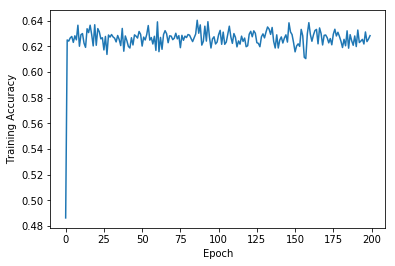

In [46]:
plt.plot(acc_full)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.savefig('train_acc.png')

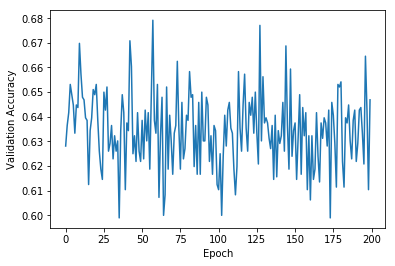

In [47]:
plt.plot(val_acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.savefig('val_acc.png')

In [48]:
def test_accuracy(batch_size, x_test, y_test, sent_attn_model):
    acc = []
    test_length = len(x_test)
    for j in range(int(test_length/batch_size)):
        x,y = gen_batch(x_test,y_test,batch_size)
        state_word = sent_attn_model.init_hidden_word()
        state_sent = sent_attn_model.init_hidden_sent()
        
        y_pred, state_sent = sent_attn_model(x, state_sent, state_word)
        max_index = y_pred.max(dim = 1)[1]
        correct = (max_index == torch.cuda.LongTensor(y)).sum()
        acc.append(float(correct)/batch_size)
    return np.mean(acc)

In [49]:
test_accuracy(batch_size, X_test_pad, y_test_tensor, sent_attn)

0.646875